<a href="https://colab.research.google.com/github/syedjaleel850/projectdr/blob/main/Copy_of_Diabetic_Retinopathy_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

class MoEFFNGating(nn.Module):
    def __init__(self, dim, hidden_dim, num_experts):
        super(MoEFFNGating, self).__init__()
        self.gating_network = nn.Linear(dim, dim)
        self.experts = nn.ModuleList([nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)) for _ in range(num_experts)])

    def forward(self, x):
        weights = self.gating_network(x)
        weights = torch.nn.functional.softmax(weights, dim=-1)
        outputs = [expert(x) for expert in self.experts]
        outputs = torch.stack(outputs, dim=0)
        outputs = (weights.unsqueeze(0) * outputs).sum(dim=0)
        return outputs

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        flops = 0
        flops += N * self.dim * 3 * self.dim
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        flops += N * self.dim * self.dim
        return flops

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        flops += self.dim * H * W
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        flops += self.dim * H * W
        return flops

class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1)
        x = x.view(B, -1, 4 * C)
        x = self.norm(x)
        x = self.reduction(x)
        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False) if dim_scale == 2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C // 4)
        x = x.view(B, -1, C // 4)
        x = self.norm(x)
        return x

class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 16 * dim, bias=False)
        self.output_dim = dim
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale,
                      c=C // (self.dim_scale ** 2))
        x = x.view(B, -1, self.output_dim)
        x = self.norm(x)
        return x

class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

class BasicLayer_up(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x

class PatchEmbed(nn.Module):
    def __init__(self, img_size=256, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

class SwinTransformerSys(nn.Module):
    def __init__(self, img_size=256, patch_size=4, in_chans=3, num_classes=1,
                 embed_dim=96, depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()
        print(
            "SwinTransformerSys expand initial----depths:{};depths_decoder:{};drop_path_rate:{};num_classes:{}".format(
                depths,
                depths_decoder, drop_path_rate, num_classes))
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2 * int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                      int(embed_dim * 2 ** (
                                                  self.num_layers - 1 - i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer == 0:
                layer_up = PatchExpand(
                    input_resolution=(patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                      patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                    dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                         input_resolution=(
                                         patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                         patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                                         depth=depths[(self.num_layers - 1 - i_layer)],
                                         num_heads=num_heads[(self.num_layers - 1 - i_layer)],
                                         window_size=window_size,
                                         mlp_ratio=self.mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop_rate, attn_drop=attn_drop_rate,
                                         drop_path=dpr[sum(depths[:(self.num_layers - 1 - i_layer)]):sum(
                                             depths[:(self.num_layers - 1 - i_layer) + 1])],
                                         norm_layer=norm_layer,
                                         upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                         use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)
        self.norm = norm_layer(self.num_features)
        self.norm_up = norm_layer(self.embed_dim)
        if self.final_upsample == "expand_first":
            print("---final upsample expand_first---")
            self.up = FinalPatchExpand_X4(input_resolution=(img_size // patch_size, img_size // patch_size),
                                          dim_scale=4, dim=embed_dim)
            self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []
        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)
        x = self.norm(x)
        return x, x_downsample

    def forward_up_features(self, x, x_downsample):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x, x_downsample[3 - inx]], -1)
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)
        x = self.norm_up(x)
        return x

    def up_x4(self, x):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "input features has wrong size"
        if self.final_upsample == "expand_first":
            x = self.up(x)
            x = x.view(B, 4 * H, 4 * W, -1)
            x = x.permute(0, 3, 1, 2)
            x = self.output(x)
            x = x.permute(0, 2, 3, 1)
        return x

    def forward(self, x):
        x, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x, x_downsample)
        x = self.up_x4(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# coding=utf-8
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import logging
import math

from os.path import join as pjoin

import torch
import torch.nn as nn
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage

logger = logging.getLogger(__name__)

class SwinUnet(nn.Module):
    def __init__(self, config, img_size=224, num_classes=1, zero_head=False, vis=False):
        super(SwinUnet, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.config = config

        self.swin_unet = SwinTransformerSys(img_size=config.DATA.IMG_SIZE,
                                patch_size=config.MODEL.SWIN.PATCH_SIZE,
                                in_chans=config.MODEL.SWIN.IN_CHANS,
                                num_classes=self.num_classes,
                                embed_dim=config.MODEL.SWIN.EMBED_DIM,
                                depths=config.MODEL.SWIN.DEPTHS,
                                num_heads=config.MODEL.SWIN.NUM_HEADS,
                                window_size=config.MODEL.SWIN.WINDOW_SIZE,
                                mlp_ratio=config.MODEL.SWIN.MLP_RATIO,
                                qkv_bias=config.MODEL.SWIN.QKV_BIAS,
                                qk_scale=config.MODEL.SWIN.QK_SCALE,
                                drop_rate=config.MODEL.DROP_RATE,
                                drop_path_rate=config.MODEL.DROP_PATH_RATE,
                                ape=config.MODEL.SWIN.APE,
                                patch_norm=config.MODEL.SWIN.PATCH_NORM,
                                use_checkpoint=config.TRAIN.USE_CHECKPOINT)

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        logits = self.swin_unet(x)
        return logits

    def load_from(self, config):
        pretrained_path = config.MODEL.PRETRAIN_CKPT
        if pretrained_path is not None:
            print("pretrained_path:{}".format(pretrained_path))
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            pretrained_dict = torch.load(pretrained_path, map_location=device)
            if "model"  not in pretrained_dict:
                print("---start load pretrained modle by splitting---")
                pretrained_dict = {k[17:]:v for k,v in pretrained_dict.items()}
                for k in list(pretrained_dict.keys()):
                    if "output" in k:
                        print("delete key:{}".format(k))
                        del pretrained_dict[k]
                msg = self.swin_unet.load_state_dict(pretrained_dict,strict=False)
                # print(msg)
                return
            pretrained_dict = pretrained_dict['model']
            print("---start load pretrained modle of swin encoder---")

            model_dict = self.swin_unet.state_dict()
            full_dict = copy.deepcopy(pretrained_dict)
            for k, v in pretrained_dict.items():
                if "layers." in k:
                    current_layer_num = 3-int(k[7:8])
                    current_k = "layers_up." + str(current_layer_num) + k[8:]
                    full_dict.update({current_k:v})
            for k in list(full_dict.keys()):
                if k in model_dict:
                    if full_dict[k].shape != model_dict[k].shape:
                        print("delete:{};shape pretrain:{};shape model:{}".format(k,v.shape,model_dict[k].shape))
                        del full_dict[k]

            msg = self.swin_unet.load_state_dict(full_dict, strict=False)
            # print(msg)
        else:
            print("none pretrain")

class Config:
    DATA = type('DATA', (object,), {'IMG_SIZE': 192, 'MASK_PATCH_SIZE': 32, 'MASK_RATIO': 0.6})
    MODEL = type('MODEL', (object,), {
        'SWIN': type('SWIN', (object,), {
            'PATCH_SIZE': 4,
            'IN_CHANS': 3,
            'EMBED_DIM': 128,
            'DEPTHS': [2, 2, 18, 2],
            'NUM_HEADS': [4, 8, 16, 32],
            'WINDOW_SIZE': 6,  # Ensure this divides evenly into 192
            'MLP_RATIO': 4.0,
            'QKV_BIAS': True,
            'QK_SCALE': None,
            'APE': False,
            'PATCH_NORM': True
        }),
        'DROP_RATE': 0.0,
        'DROP_PATH_RATE': 0.0
    })
    TRAIN = type('TRAIN', (object,), {
        'EPOCHS': 400,
        'WARMUP_EPOCHS': 10,
        'BASE_LR': 2e-4,
        'WARMUP_LR': 1e-6,
        'MIN_LR': 1e-5,
        'WEIGHT_DECAY': 0.05,
        'USE_CHECKPOINT': False
    })
    PRINT_FREQ = 100
    SAVE_FREQ = 5
    TAG = "simmim_pretrain__swin_base__img192_window6__100ep"

config = Config()
model = SwinUnet(config, img_size=config.DATA.IMG_SIZE, num_classes=1)


SwinTransformerSys expand initial----depths:[2, 2, 18, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.0;num_classes:1


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


Number of images in the dataset: 54


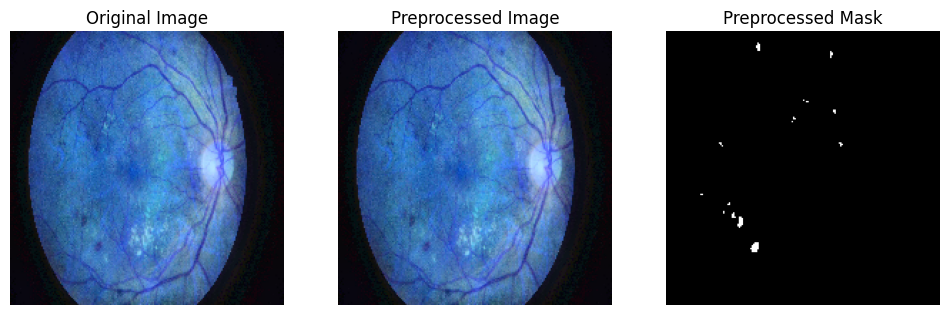

In [9]:
# Normal code for fgadr
# import os
# import cv2
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# # import segmentation_models_pytorch as smp
# # from segmentation_models_pytorch.encoders import get_encoder
# import torchvision.transforms as transforms
# from PIL import Image
# import matplotlib.pyplot as plt

# # Preprocessing function for images
# def preprocess_image(image, target_size=(512, 512)):
#     # Resize image
#     resized_image = cv2.resize(image, target_size)

#     # Apply CLAHE for contrast enhancement to each channel
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     enhanced_image = np.zeros_like(resized_image)
#     for i in range(3):
#         enhanced_image[:, :, i] = clahe.apply(resized_image[:, :, i])

#     # Normalize pixel values to [0, 1]
#     normalized_image = enhanced_image / 255.0

#     return normalized_image

# # Preprocessing function for masks
# def preprocess_mask(mask, target_size=(512, 512)):
#     if mask is None or mask.size == 0:
#         raise ValueError("Mask is empty or not read correctly.")
#     # Resize mask
#     resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
#     # Normalize mask values to [0, 1]
#     normalized_mask = resized_mask / 255.0
#     return normalized_mask

# # Custom dataset class
# class SegmentationDataset(Dataset):
#     def __init__(self, image_folder, mask_folders, target_size = (512, 512)):
#         self.image_folder = image_folder
#         self.mask_folders = mask_folders
#         self.target_size = target_size
#         self.image_names = [f for f in sorted(os.listdir(image_folder)) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
#         self.num_lesions = len(mask_folders)

#     def __len__(self):
#         return len(self.image_names)

#     def __getitem__(self, idx):
#         img_name = self.image_names[idx]
#         img_path = os.path.join(self.image_folder, img_name)
#         img = cv2.imread(img_path)
#         if img is None:
#             raise ValueError(f"Image {img_path} not read correctly.")
#         preprocessed_img = preprocess_image(img, self.target_size)

#         masks = np.zeros((self.target_size[0], self.target_size[1], self.num_lesions))
#         for lesion_index, lesion_folder in enumerate(self.mask_folders):
#             mask_name = img_name.replace('.png', '.png')  # Ensure the mask is in PNG format
#             mask_path = os.path.join(lesion_folder, mask_name)
#             if not os.path.exists(mask_path):
#                 raise FileNotFoundError(f"Mask file {mask_path} does not exist.")
#             mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
#             preprocessed_mask = preprocess_mask(mask, self.target_size)
#             masks[:, :, lesion_index] = preprocessed_mask

#         preprocessed_img = np.transpose(preprocessed_img, (2, 0, 1))
#         masks = np.sum(masks, axis=-1, keepdims=True)
#         masks = np.transpose(masks, (2, 0, 1))

#         return torch.tensor(preprocessed_img, dtype=torch.float32), torch.tensor(masks, dtype=torch.float32)

# # Define paths
# image_folder = "/content/drive/MyDrive/segset/Original images copy"
# mask_folders = [
#     "/content/drive/MyDrive/segset/Hemohedge_Maskscopy"
# ]

# # Create dataset and data loaders
# dataset = SegmentationDataset(image_folder, mask_folders, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE))
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# # Print the number of images
# print(f"Number of images in the dataset: {len(dataset)}")

# # Debugging: Visualize the first image and mask at different stages
# def visualize_sample(dataset, idx):
#     img, mask = dataset[idx]
#     img = img.numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
#     mask = mask.numpy().squeeze()  # Convert to (H, W)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 3, 1)
#     plt.title('Original Image')
#     plt.imshow(img)
#     plt.axis('off')

#     plt.subplot(1, 3, 2)
#     plt.title('Preprocessed Image')
#     plt.imshow(img)
#     plt.axis('off')

#     plt.subplot(1, 3, 3)
#     plt.title('Preprocessed Mask')
#     plt.imshow(mask, cmap='gray')
#     plt.axis('off')

#     plt.show()

# # Visualize the first sample
# visualize_sample(dataset, 0)

# # Define the save path for the model checkpoints
# save_path = "/content/drive/MyDrive/Project DR"

# # Ensure the save path directory exists
# os.makedirs(save_path, exist_ok=True)


# Normal  code for idrid dataset to run
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Preprocessing function for images
def preprocess_image(image, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE)):
    # Resize image
    resized_image = cv2.resize(image, target_size)

    # Apply CLAHE for contrast enhancement to each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = np.zeros_like(resized_image)
    for i in range(3):
        enhanced_image[:, :, i] = clahe.apply(resized_image[:, :, i])

    # Normalize pixel values to [0, 1]
    normalized_image = enhanced_image / 255.0

    return normalized_image

# Preprocessing function for masks
def preprocess_mask(mask, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE)):
    if mask is None or mask.size == 0:
        raise ValueError("Mask is empty or not read correctly.")
    # Resize mask
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    # Normalize mask values to [0, 1]
    normalized_mask = resized_mask / 255.0
    return normalized_mask

# Custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_folder, mask_folders, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE)):
        self.image_folder = image_folder
        self.mask_folders = mask_folders
        self.target_size = target_size
        self.image_names = [f for f in sorted(os.listdir(image_folder)) if f.lower().endswith(('.jpg', '.jpeg'))]
        self.num_lesions = len(mask_folders)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Image {img_path} not read correctly.")
        preprocessed_img = preprocess_image(img, self.target_size)

        masks = np.zeros((self.target_size[0], self.target_size[1], self.num_lesions))
        for lesion_index, lesion_folder in enumerate(self.mask_folders):
            mask_name = img_name.replace('.jpg', '_HE.tif')  # Ensure the mask is in TIFF format
            mask_path = os.path.join(lesion_folder, mask_name)
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask file {mask_path} does not exist.")
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            preprocessed_mask = preprocess_mask(mask, self.target_size)
            masks[:, :, lesion_index] = preprocessed_mask

        preprocessed_img = np.transpose(preprocessed_img, (2, 0, 1))
        masks = np.sum(masks, axis=-1, keepdims=True)
        masks = np.transpose(masks, (2, 0, 1))

        return torch.tensor(preprocessed_img, dtype=torch.float32), torch.tensor(masks, dtype=torch.float32)

# Define paths
image_folder = "/content/drive/MyDrive/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set"
mask_folders = [
    "/content/drive/MyDrive/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages"
]

# Create dataset and data loaders
dataset = SegmentationDataset(image_folder, mask_folders, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# Print the number of images
print(f"Number of images in the dataset: {len(dataset)}")

# Debugging: Visualize the first image and mask at different stages
def visualize_sample(dataset, idx):
    img, mask = dataset[idx]
    img = img.numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
    mask = mask.numpy().squeeze()  # Convert to (H, W)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Preprocessed Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Preprocessed Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Visualize the first sample
visualize_sample(dataset, 0)

# Define the save path for the model checkpoints
save_path = "/content/drive/MyDrive/Project DR/IDRID haemorrhages"

# Ensure the save path directory exists
os.makedirs(save_path, exist_ok=True)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=config.TRAIN.BASE_LR, weight_decay=config.TRAIN.WEIGHT_DECAY)

import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

dice_loss = DiceLoss()
focal_loss = FocalLoss()

def combined_loss(outputs, masks):
    return dice_loss(outputs, masks) + focal_loss(outputs, masks)

def iou_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    intersection = (outputs * masks).sum()
    union = outputs.sum() + masks.sum() - intersection
    iou = intersection / union
    return iou.item()

def f1_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fp = (outputs * (1 - masks)).sum()
    fn = ((1 - outputs) * masks).sum()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1.item()

def pixel_accuracy(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    correct = (outputs == masks).sum()
    total = masks.numel()
    accuracy = correct / total
    return accuracy.item()

def precision(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fp = (outputs * (1 - masks)).sum()
    precision = tp / (tp + fp + 1e-8)
    return precision.item()

def recall(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fn = ((1 - outputs) * masks).sum()
    recall = tp / (tp + fn + 1e-8)
    return recall.item()

# Training loop
for epoch in range(config.TRAIN.EPOCHS):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    iou_scores = []
    f1_scores = []
    pixel_accuracies = []
    precisions = []
    recalls = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
            iou_scores.append(iou_score(outputs, masks))
            f1_scores.append(f1_score(outputs, masks))
            pixel_accuracies.append(pixel_accuracy(outputs, masks))
            precisions.append(precision(outputs, masks))
            recalls.append(recall(outputs, masks))

    avg_iou = np.mean(iou_scores)
    avg_f1 = np.mean(f1_scores)
    avg_pixel_accuracy = np.mean(pixel_accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    print(f"Epoch {epoch+1}/{config.TRAIN.EPOCHS}, Loss: {epoch_loss/len(train_loader)}")
    print(f"Epoch {epoch+1}/{config.TRAIN.EPOCHS}, IoU: {avg_iou}, F1 Score: {avg_f1}, Pixel Accuracy: {avg_pixel_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}")

    # Save the model after every 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint_path = os.path.join(save_path, f'model_epoch_{epoch+1}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Model saved at epoch {epoch+1} to {checkpoint_path}")

    # Print the ground truth, predicted, and original image from the training dataset after every 5 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            for images, masks in train_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
                break

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title('Original Image (Training)')
        plt.imshow(images[0].cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask (Training)')
        plt.imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask (Training)')
        plt.imshow(torch.sigmoid(outputs[0]).cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')

        plt.show()


In [ ]:
#trained model testing code
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Preprocessing function for images
def preprocess_image(image, target_size=(512, 512)):
    # Resize image
    resized_image = cv2.resize(image, target_size)

    # Apply CLAHE for contrast enhancement to each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = np.zeros_like(resized_image)
    for i in range(3):
        enhanced_image[:, :, i] = clahe.apply(resized_image[:, :, i])

    # Normalize pixel values to [0, 1]
    normalized_image = enhanced_image / 255.0

    return normalized_image

# Preprocessing function for masks
def preprocess_mask(mask, target_size=(512, 512)):
    if mask is None or mask.size == 0:
        raise ValueError("Mask is empty or not read correctly.")
    # Resize mask
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    # Normalize mask values to [0, 1]
    normalized_mask = resized_mask / 255.0
    return normalized_mask

# Define the save path
save_path = '/content/drive/MyDrive/Project DR'
checkpoint_path = os.path.join(save_path, 'model_epoch_400.pth')

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)

# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=config.TRAIN.BASE_LR, weight_decay=config.TRAIN.WEIGHT_DECAY)

import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

dice_loss = DiceLoss()
focal_loss = FocalLoss()

def combined_loss(outputs, masks):
    return dice_loss(outputs, masks) + focal_loss(outputs, masks)

def iou_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    intersection = (outputs * masks).sum()
    union = outputs.sum() + masks.sum() - intersection
    iou = intersection / union
    return iou.item()

def f1_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fp = (outputs * (1 - masks)).sum()
    fn = ((1 - outputs) * masks).sum()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1.item()

# Test the model on a specific image by providing its path
image_path = "/content/drive/MyDrive/Seg-set copy/Original_Images/0014_3.png"  # Replace with the actual image path
mask_path = "/content/drive/MyDrive/Seg-set copy/HardExudate_Masks/0014_3.png"  # Replace with the actual mask path

# Load and preprocess the image
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Image {image_path} not read correctly.")
preprocessed_img = preprocess_image(image, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE))
preprocessed_img = np.transpose(preprocessed_img, (2, 0, 1))
image_tensor = torch.tensor(preprocessed_img, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Load and preprocess the mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise ValueError(f"Mask {mask_path} not read correctly.")
preprocessed_mask = preprocess_mask(mask, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE))
preprocessed_mask = np.expand_dims(preprocessed_mask, axis=0)  # Add channel dimension
mask_tensor = torch.tensor(preprocessed_mask, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Move tensors to the appropriate device
image_tensor, mask_tensor = image_tensor.to(device), mask_tensor.to(device)

model.eval()
with torch.no_grad():
    outputs = model(image_tensor)
    outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
    iou = iou_score(outputs, mask_tensor)
    f1 = f1_score(outputs, mask_tensor)

print(f"Testing IoU: {iou}, F1 Score: {f1}")

# Visualize the results for the specific image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_tensor.cpu().numpy().transpose(0, 2, 3, 1)[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_tensor.cpu().numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(torch.sigmoid(outputs[0]).cpu().numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.show()


<ipython-input-7-9a1a5a41f42e>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Testing IoU: 0.7515274882316589, F1 Score: 0.8581395149230957


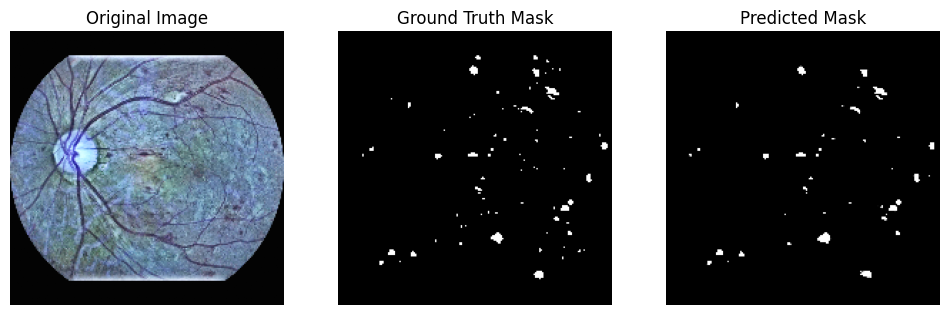

In [7]:
#trained model testing code 1

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Preprocessing function for images
def preprocess_image(image, target_size=(512, 512)):
    # Resize image
    resized_image = cv2.resize(image, target_size)

    # Apply CLAHE for contrast enhancement to each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = np.zeros_like(resized_image)
    for i in range(3):
        enhanced_image[:, :, i] = clahe.apply(resized_image[:, :, i])

    # Normalize pixel values to [0, 1]
    normalized_image = enhanced_image / 255.0

    return normalized_image

# Preprocessing function for masks
def preprocess_mask(mask, target_size=(512, 512)):
    if mask is None or mask.size == 0:
        raise ValueError("Mask is empty or not read correctly.")
    # Resize mask
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    # Normalize mask values to [0, 1]
    normalized_mask = resized_mask / 255.0
    return normalized_mask

# Define the save path
save_path = '/content/drive/MyDrive/Project DR'
checkpoint_path = os.path.join(save_path, 'model_epoch_350.pth')

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=config.TRAIN.BASE_LR, weight_decay=config.TRAIN.WEIGHT_DECAY)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

dice_loss = DiceLoss()
focal_loss = FocalLoss()

def combined_loss(outputs, masks):
    return dice_loss(outputs, masks) + focal_loss(outputs, masks)

def iou_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    intersection = (outputs * masks).sum()
    union = outputs.sum() + masks.sum() - intersection
    iou = intersection / union
    return iou.item()

def f1_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fp = (outputs * (1 - masks)).sum()
    fn = ((1 - outputs) * masks).sum()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1.item()

# Test the model on a specific image by providing its path
image_path = "/content/drive/MyDrive/segset/Original images copy/381.png"  # Replace with the actual image path
mask_path = "/content/drive/MyDrive/segset/Hemohedge_Maskscopy/381.png"  # Replace with the actual mask path

# Load and preprocess the image
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Image {image_path} not read correctly.")
preprocessed_img = preprocess_image(image, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE))
preprocessed_img = np.transpose(preprocessed_img, (2, 0, 1))
image_tensor = torch.tensor(preprocessed_img, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Load and preprocess the mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise ValueError(f"Mask {mask_path} not read correctly.")
preprocessed_mask = preprocess_mask(mask, target_size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE))
preprocessed_mask = np.expand_dims(preprocessed_mask, axis=0)  # Add channel dimension
mask_tensor = torch.tensor(preprocessed_mask, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Move tensors to the appropriate device
image_tensor, mask_tensor = image_tensor.to(device), mask_tensor.to(device)

model.eval()
with torch.no_grad():
    outputs = model(image_tensor)
    outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
    iou = iou_score(outputs, mask_tensor)
    f1 = f1_score(outputs, mask_tensor)

print(f"Testing IoU: {iou}, F1 Score: {f1}")

# Visualize the results for the specific image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_tensor.cpu().numpy().transpose(0, 2, 3, 1)[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_tensor.cpu().numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(torch.sigmoid(outputs[0]).cpu().numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.show()


In [12]:
# Train the model further 1

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the model, optimizer, and loss functions
model = SwinUnet(config, img_size=config.DATA.IMG_SIZE, num_classes=1)
model = model.to(device)

# Load the checkpoint
checkpoint_path = '/content/drive/MyDrive/Project DR/model_epoch_400.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=config.TRAIN.BASE_LR, weight_decay=config.TRAIN.WEIGHT_DECAY)

# Load the optimizer state dictionary if available
if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the starting epoch
start_epoch = 201

# Training loop
for epoch in range(start_epoch, config.TRAIN.EPOCHS):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks

        # Resize the outputs to match the shape of the masks
        outputs = torch.nn.functional.interpolate(outputs, size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE), mode='bilinear', align_corners=True)



        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    iou_scores = []
    f1_scores = []
    pixel_accuracies = []
    precisions = []
    recalls = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks

            # Resize the outputs to match the shape of the masks
            outputs = torch.nn.functional.interpolate(outputs, size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE), mode='bilinear', align_corners=True)

            iou_scores.append(iou_score(outputs, masks))
            f1_scores.append(f1_score(outputs, masks))
            pixel_accuracies.append(pixel_accuracy(outputs, masks))
            precisions.append(precision(outputs, masks))
            recalls.append(recall(outputs, masks))

    avg_iou = np.mean(iou_scores)
    avg_f1 = np.mean(f1_scores)
    avg_pixel_accuracy = np.mean(pixel_accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    print(f"Epoch {epoch+1}/{config.TRAIN.EPOCHS}, Loss: {epoch_loss/len(train_loader)}")
    print(f"Epoch {epoch+1}/{config.TRAIN.EPOCHS}, IoU: {avg_iou}, F1 Score: {avg_f1}, Pixel Accuracy: {avg_pixel_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}")

    # Save the model after every 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint_path = os.path.join(save_path, f'model_epoch_{epoch+1}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Model saved at epoch {epoch+1} to {checkpoint_path}")

    # Print the ground truth, predicted, and original image from the training dataset after every 5 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            for images, masks in train_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks

                # Resize the outputs to match the shape of the masks
                outputs = torch.nn.functional.interpolate(outputs, size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE), mode='bilinear', align_corners=True)

                break

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title('Original Image (Training)')
        plt.imshow(images[0].cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask (Training)')
        plt.imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask (Training)')
        plt.imshow(torch.sigmoid(outputs[0]).cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')

        plt.show()


SwinTransformerSys expand initial----depths:[2, 2, 18, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.0;num_classes:1
---final upsample expand_first---


<ipython-input-12-d3771029d22d>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.11/dis

NameError: name 'F' is not defined

In [ ]:
# Train the model further
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the save path
save_path = '/content'
checkpoint_path = os.path.join(save_path, 'model_epoch_100.pth')

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Check if the checkpoint contains the optimizer state
if 'model_state_dict' in checkpoint and 'optimizer_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.AdamW(model.parameters(), lr=config.TRAIN.BASE_LR, weight_decay=config.TRAIN.WEIGHT_DECAY)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    model.load_state_dict(checkpoint)
    optimizer = optim.AdamW(model.parameters(), lr=config.TRAIN.BASE_LR, weight_decay=config.TRAIN.WEIGHT_DECAY)

import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

dice_loss = DiceLoss()
focal_loss = FocalLoss()

def combined_loss(outputs, masks):
    return dice_loss(outputs, masks) + focal_loss(outputs, masks)

def iou_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    intersection = (outputs * masks).sum()
    union = outputs.sum() + masks.sum() - intersection
    iou = intersection / union
    return iou.item()

def f1_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fp = (outputs * (1 - masks)).sum()
    fn = ((1 - outputs) * masks).sum()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1.item()

# Training loop
start_epoch = 101  # Start from the 101st epoch
for epoch in range(start_epoch, config.TRAIN.EPOCHS + 1):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    iou_scores = []
    f1_scores = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
            iou_scores.append(iou_score(outputs, masks))
            f1_scores.append(f1_score(outputs, masks))

    avg_iou = np.mean(iou_scores)
    avg_f1 = np.mean(f1_scores)

    print(f"Epoch {epoch}/{config.TRAIN.EPOCHS}, Loss: {epoch_loss/len(train_loader)}")
    print(f"Epoch {epoch}/{config.TRAIN.EPOCHS}, IoU: {avg_iou}, F1 Score: {avg_f1}")

    # Visualize the results after each epoch
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
            break

    # Visualize the first image and its masks
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(images[0].cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(torch.sigmoid(outputs[0]).cpu().numpy().squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

    # Save the model after every 50 epochs
    if (epoch) % 50 == 0:
        checkpoint_path = os.path.join(save_path, f'model_epoch_{epoch}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Model saved at epoch {epoch} to {checkpoint_path}")

# Save the model after the final epoch
final_checkpoint_path = os.path.join(save_path, f'model_epoch_{config.TRAIN.EPOCHS}.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, final_checkpoint_path)
print(f"Model saved at epoch {config.TRAIN.EPOCHS} to {final_checkpoint_path}")


In [ ]:
!pip install tensorflow opencv-python-headless scikit-learn


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, train_loader, val_loader, config, save_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.TRAIN.BASE_LR,
        weight_decay=config.TRAIN.WEIGHT_DECAY
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )

    dice_loss = DiceLoss().to(device)
    focal_loss = FocalLoss().to(device)
    early_stopping = EarlyStopping(patience=10)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_metrics = {'iou': [], 'dice': [], 'accuracy': []}

    for epoch in range(config.TRAIN.EPOCHS):
        # Training phase
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.TRAIN.EPOCHS}')

        for batch in progress_bar:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = dice_loss(outputs, masks) + focal_loss(outputs, masks)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_acc = 0

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)

                outputs = model(images)
                loss = dice_loss(outputs, masks) + focal_loss(outputs, masks)
                val_loss += loss.item()

                # Calculate metrics
                predictions = (torch.sigmoid(outputs) > 0.5).float()
                val_iou += ((predictions * masks).sum() / ((predictions + masks) > 0).sum()).item()
                val_dice += (2 * (predictions * masks).sum() / (predictions.sum() + masks.sum())).item()
                val_acc += (predictions == masks).float().mean().item()

        # Average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)

        val_losses.append(avg_val_loss)
        val_metrics['iou'].append(avg_val_iou)
        val_metrics['dice'].append(avg_val_dice)
        val_metrics['accuracy'].append(avg_val_acc)

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Print metrics
        print(f"\nEpoch {epoch+1}/{config.TRAIN.EPOCHS}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}, Acc: {avg_val_acc:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': best_val_loss,
            }, f"{save_path}/best_model.pth")

        # Early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Visualize predictions
        if (epoch + 1) % 5 == 0:
            visualize_predictions(model, val_loader, device, epoch + 1)

    return train_losses, val_losses, val_metrics

def visualize_predictions(model, val_loader, device, epoch):
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs) > 0.5

        # Plot results
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        for i in range(2):
            # Original image
            axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0))
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            # Ground truth
            axes[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            # Prediction
            axes[i, 2].imshow(predictions[i].cpu)

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def remove_vessels(image):
    """Remove blood vessels using morphological operations"""
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Apply morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

    return closed

def extract_green_channel(image):
    """Extract and enhance the green channel"""
    # Extract green channel
    green_channel = image[:, :, 1]

    # Enhance green channel contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_green = clahe.apply(green_channel)

    return np.stack([enhanced_green]*3, axis=-1)

def reduce_noise(image):
    """Reduce noise while preserving edges"""
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised

def enhance_dark_regions(image):
    """Enhance dark regions where hemorrhages typically appear"""
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab[..., 0] = clahe.apply(lab[..., 0])

    # Convert back to BGR
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return enhanced

def preprocess_image(image, target_size=(512, 512)):
    """Main preprocessing pipeline for images"""
    if image is None or image.size == 0:
        raise ValueError("Input image is empty or invalid")

    # Resize image
    resized_image = cv2.resize(image, target_size)

    # Apply noise reduction
    denoised = reduce_noise(resized_image)

    # Extract and enhance green channel
    green_enhanced = extract_green_channel(denoised)

    # Enhance dark regions
    dark_enhanced = enhance_dark_regions(green_enhanced)

    # Remove vessels
    no_vessels = remove_vessels(dark_enhanced)

    # Final normalization
    normalized_image = no_vessels.astype(np.float32) / 255.0

    return normalized_image

def preprocess_mask(mask, target_size=(512, 512)):
    """Preprocessing pipeline for masks"""
    if mask is None or mask.size == 0:
        raise ValueError("Mask is empty or invalid")

    # Resize mask using nearest neighbor interpolation
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Ensure binary mask
    binary_mask = (resized_mask > 127).astype(np.float32)

    return binary_mask

class HemorrhageDataset(Dataset):
    def __init__(self, image_folder, mask_folder, target_size=(512, 512), augment=True):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.target_size = target_size
        self.augment = augment

        # Get list of images
        self.image_names = [f for f in sorted(os.listdir(image_folder))
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

    def __len__(self):
        return len(self.image_names)

    def augment_data(self, image, mask):
        """Apply data augmentation"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)

        # Random rotation
        if np.random.random() > 0.5:
            angle = np.random.uniform(-10, 10)
            height, width = image.shape[:2]
            matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1.0)
            image = cv2.warpAffine(image, matrix, (width, height))
            mask = cv2.warpAffine(mask, matrix, (width, height))

        return image, mask

    def __getitem__(self, idx):
        # Load image and mask
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, img_name)
        mask_path = os.path.join(self.mask_folder, img_name.replace('.jpg', '_mask.png'))

        # Read image and mask
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Failed to load image or mask: {img_path}")

        # Apply augmentation if enabled
        if self.augment:
            image, mask = self.augment_data(image, mask)

        # Apply preprocessing
        preprocessed_img = preprocess_image(image, self.target_size)
        preprocessed_mask = preprocess_mask(mask, self.target_size)

        # Convert to torch tensors
        preprocessed_img = np.transpose(preprocessed_img, (2, 0, 1))
        preprocessed_mask = preprocessed_mask[np.newaxis, ...]

        return {
            'image': torch.tensor(preprocessed_img, dtype=torch.float32),
            'mask': torch.tensor(preprocessed_mask, dtype=torch.float32),
            'image_path': img_path
        }

def create_dataloaders(image_folder, mask_folder, batch_size=4, train_split=0.8):
    """Create train and validation dataloaders"""
    # Create dataset
    dataset = HemorrhageDataset(image_folder, mask_folder)

    # Split into train and validation
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=4,
                            pin_memory=True)

    val_loader = DataLoader(val_dataset,
                           batch_size=batch_size,
                           shuffle=False,
                           num_workers=4,
                           pin_memory=True)

    return train_loader, val_loader

def visualize_preprocessing(image_path, mask_path):
    """Visualize preprocessing steps"""
    # Read image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Apply preprocessing steps
    preprocessed = preprocess_image(image)
    preprocessed_mask = preprocess_mask(mask)

    # Display results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')

    axes[0, 1].imshow(cv2.cvtColor(extract_green_channel(image), cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title('Green Channel Enhanced')

    axes[0, 2].imshow(cv2.cvtColor(enhance_dark_regions(image), cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title('Dark Regions Enhanced')

    axes[1, 0].imshow(preprocessed, cmap='gray')
    axes[1, 0].set_title('Final Preprocessed Image')

    axes[1, 1].imshow(mask, cmap='gray')
    axes[1, 1].set_title('Original Mask')

    axes[1, 2].imshow(preprocessed_mask, cmap='gray')
    axes[1, 2].set_title('Preprocessed Mask')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# [Previous preprocessing code remains the same until the end]

# Define dataset paths
image_folder = "/content/drive/MyDrive/Seg-set copy/Original_Images"
mask_folder = "/content/drive/MyDrive/Seg-set copy/Hemohedge_Masks"

# Create dataloaders
train_loader, val_loader = create_dataloaders(
    image_folder=image_folder,
    mask_folder=mask_folder,
    batch_size=4
)

# Print dataset size
print(f"Number of images in the dataset: {len(train_loader.dataset) + len(val_loader.dataset)}")

# Visualize preprocessing on a sample image
sample_image_path = os.path.join(image_folder, os.listdir(image_folder)[0])  # Get first image
sample_mask_path = os.path.join(mask_folder, os.listdir(mask_folder)[0])    # Get first mask

print("Visualizing preprocessing steps for sample image:")
visualize_preprocessing(sample_image_path, sample_mask_path)

Number of images in the dataset: 161


<ipython-input-6-cb00eeaebeb7>:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.sum(torch.tensor(masks, dtype=torch.float32), dim=-1, keepdim=True).clone().detach()


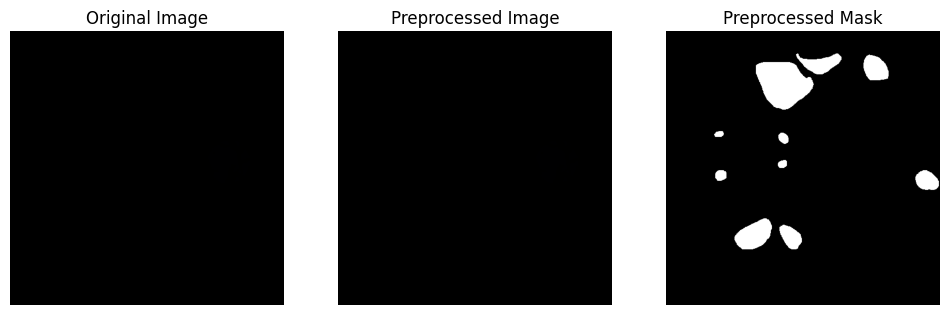

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Preprocessing function for images
def preprocess_image(image, target_size=(512, 512)):
    # Resize image
    resized_image = cv2.resize(image, target_size)

    # Apply CLAHE for contrast enhancement to each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = np.zeros_like(resized_image)
    for i in range(3):
        enhanced_image[:, :, i] = clahe.apply(resized_image[:, :, i])

    # Normalize pixel values to [0, 1]
    normalized_image = (enhanced_image / 255.0 - 0.5) * 2  # Normalize to [-1, 1]
    return normalized_image

# Preprocessing function for masks
def preprocess_mask(mask, target_size=(512, 512)):
    if mask is None or mask.size == 0:
        raise ValueError("Mask is empty or not read correctly.")
    # Resize mask
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    # Normalize mask values to [0, 1]
    normalized_mask = resized_mask / 255.0
    return normalized_mask

# Define augmentations
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.5, alpha=120, sigma=12),
    A.GridDistortion(p=0.5),
    A.CLAHE(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], is_check_shapes=False)

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], is_check_shapes=False)

# Custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_folder, mask_folders, target_size=(512, 512), transform=None):
        self.image_folder = image_folder
        self.mask_folders = mask_folders
        self.target_size = target_size
        self.transform = transform
        self.image_names = [f for f in sorted(os.listdir(image_folder)) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
        self.num_lesions = len(mask_folders)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Image {img_path} not read correctly.")
        preprocessed_img = preprocess_image(img, self.target_size)

        masks = np.zeros((self.target_size[0], self.target_size[1], self.num_lesions))
        for lesion_index, lesion_folder in enumerate(self.mask_folders):
            mask_name = img_name.replace('.png', '.png')  # Ensure the mask is in PNG format
            mask_path = os.path.join(lesion_folder, mask_name)
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask file {mask_path} does not exist.")
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            preprocessed_mask = preprocess_mask(mask, self.target_size)
            masks[:, :, lesion_index] = preprocessed_mask

        sample = {'image': preprocessed_img, 'mask': masks}
        if self.transform:
            augmented = self.transform(**sample)
            preprocessed_img = augmented['image']
            masks = augmented['mask']

        masks = torch.sum(torch.tensor(masks, dtype=torch.float32), dim=-1, keepdim=True).clone().detach()

        return preprocessed_img.clone().detach(), masks

# Define paths
image_folder = "/content/drive/MyDrive/segset/Original images copy"
mask_folders = [
    "/content/drive/MyDrive/segset/Hemohedge_Maskscopy"
]

# Create dataset and data loaders
dataset = SegmentationDataset(image_folder, mask_folders, target_size=(512, 512))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# Print the number of images
print(f"Number of images in the dataset: {len(dataset)}")

# Debugging: Visualize the first image and mask at different stages
def visualize_sample(dataset, idx):
    img, mask = dataset[idx]

    # Denormalize the image tensor
    img = img.numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Convert the mask tensor to a NumPy array and squeeze to (H, W)
    mask = mask.numpy().squeeze()  # Convert to (H, W)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Preprocessed Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Preprocessed Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Visualize the first sample
visualize_sample(train_dataset, 0)

# Define the save path for the model checkpoints
save_path = "/content"

# Ensure the save path directory exists
os.makedirs(save_path, exist_ok=True)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the save path and checkpoint path
save_path = "/content/drive/MyDrive/Project DR"
checkpoint_path = os.path.join(save_path, 'model_epoch_200.pth')

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=config.TRAIN.BASE_LR, weight_decay=config.TRAIN.WEIGHT_DECAY)

# Load the optimizer state dictionary if available
if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Define the loss functions
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

dice_loss = DiceLoss()
focal_loss = FocalLoss()

def combined_loss(outputs, masks):
    return dice_loss(outputs, masks) + focal_loss(outputs, masks)

def iou_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    intersection = (outputs * masks).sum()
    union = outputs.sum() + masks.sum() - intersection
    iou = intersection / union
    return iou.item()

def f1_score(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fp = (outputs * (1 - masks)).sum()
    fn = ((1 - outputs) * masks).sum()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1.item()

def pixel_accuracy(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    correct = (outputs == masks).sum()
    total = masks.numel()
    accuracy = correct / total
    return accuracy.item()

def precision(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fp = (outputs * (1 - masks)).sum()
    precision = tp / (tp + fp + 1e-8)
    return precision.item()

def recall(outputs, masks, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    tp = (outputs * masks).sum()
    fn = ((1 - outputs) * masks).sum()
    recall = tp / (tp + fn + 1e-8)
    return recall.item()

# Resume training from the specified epoch
start_epoch = 300

# Training loop
for epoch in range(start_epoch, config.TRAIN.EPOCHS):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    iou_scores = []
    f1_scores = []
    pixel_accuracies = []
    precisions = []
    recalls = []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
            iou_scores.append(iou_score(outputs, masks))
            f1_scores.append(f1_score(outputs, masks))
            pixel_accuracies.append(pixel_accuracy(outputs, masks))
            precisions.append(precision(outputs, masks))
            recalls.append(recall(outputs, masks))

    avg_iou = np.mean(iou_scores)
    avg_f1 = np.mean(f1_scores)
    avg_pixel_accuracy = np.mean(pixel_accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    print(f"Epoch {epoch+1}/{config.TRAIN.EPOCHS}, Loss: {epoch_loss/len(train_loader)}")
    print(f"Epoch {epoch+1}/{config.TRAIN.EPOCHS}, IoU: {avg_iou}, F1 Score: {avg_f1}, Pixel Accuracy: {avg_pixel_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}")

    # Save the model after every 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint_path = os.path.join(save_path, f'model_epoch_{epoch+1}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Model saved at epoch {epoch+1} to {checkpoint_path}")

    # Print the ground truth, predicted, and original image from the training dataset after every 5 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            for images, masks in train_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = outputs.permute(0, 3, 1, 2)  # Change the shape to match masks
                break

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title('Original Image (Training)')
        plt.imshow(images[0].cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask (Training)')
        plt.imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask (Training)')
        plt.imshow(torch.sigmoid(outputs[0]).cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')

        plt.show()


In [ ]:
from PIL import Image
import os
import glob
import math
import numpy as np
import cv2
from skimage import data, io

def zoom(img_path, label_path, img_savedir, label_savedir, mixlabel_savedir, size=(2752,2752), ds='IDRiD'):
    def convert(img, width=size[1], height=size[0], mode='L'):
        img = Image.fromarray(img)
        h, w = img.size
        shift = int(abs(h - w) * 0.5)
        if mode == 'RGB':
            ch = (0, 0, 0)
            resize_mode = Image.LANCZOS  # Change this line
        else:
            ch = 0
            resize_mode = Image.NEAREST
        if h > w:  # Add padding to make it a square
            length = h
            new_pic = Image.new(mode, (length, length), color=ch)
            new_pic.paste(img, (0, shift))
        else:
            length = w
            new_pic = Image.new(mode, (length, length), color=ch)
            new_pic.paste(img, (shift, 0))

        new_img = new_pic.resize((width, height), resize_mode)
        return np.asarray(new_img)

    if ds == 'IDRiD':
        max_width = []
        max_hight = []
        if not os.path.exists(img_savedir):
            os.makedirs(img_savedir)
        if not os.path.exists(label_savedir):
            os.makedirs(label_savedir)
        if not os.path.exists(mixlabel_savedir):
            os.makedirs(mixlabel_savedir)

        fileList = os.listdir(img_path)
        for jpgfile in fileList:
            (realname, extension) = os.path.splitext(jpgfile)
            img = cv2.imread(os.path.join(img_path, jpgfile))
            print(realname)
            dst = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            label = cv2.imread(os.path.join(label_path, realname + '_HE.tif'), cv2.IMREAD_GRAYSCALE)

            dst = cv2.GaussianBlur(dst, (1, 1), 0)
            dst = cv2.blur(dst, (5, 5))
            ret, thresh = cv2.threshold(dst, 20, 255, cv2.THRESH_BINARY)
            kernel = np.ones((9, 9), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=3)
            contours, hierarchy1 = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
            print(len(contours), jpgfile)

            a = []
            for i in range(len(contours)):
                a.append(len(contours[i]))
            m = max(a)

            n = a.index(m)
            rect = cv2.minAreaRect(contours[n])

            box = np.int0(cv2.boxPoints(rect))
            Xs = [i[0] for i in box]
            Ys = [i[1] for i in box]
            x1 = min(Xs)
            x2 = max(Xs)
            y1 = min(Ys)
            y2 = max(Ys)
            hight = y2 - y1
            width = x2 - x1

            max_hight.append(hight)
            max_width.append(width)
            print(max(max_width), max(max_hight))
            crop_img = convert(img[y1:y1 + hight, x1:x1 + width], mode='RGB')
            crop_label = convert(label[y1:y1 + hight, x1:x1 + width])
            cv2.imwrite(os.path.join(img_savedir, realname + '.png'), crop_img)
            cv2.imwrite(os.path.join(label_savedir, realname + '.png'), crop_label)
            cv2.imwrite(os.path.join(mixlabel_savedir, realname + '.png'), crop_label)

def main(dataset):
    if dataset == 'IDRiD':
        img_path = '/content/drive/MyDrive/segset/Original images copy'
        label_path = '/content/drive/MyDrive/segset/Hemohedge_Maskscopy'
        img_savedir = '/content/drive/MyDrive/segset/masks/img_savedir'
        label_savedir = '/content/drive/MyDrive/segset/masks/label_savedir'
        mixlabel_savedir = '/content/drive/MyDrive/segset/masks/mixlabel_savedir'
        zoom(img_path, label_path, img_savedir, label_savedir, mixlabel_savedir, size=(2752,2752), ds='IDRiD')

# Set the dataset argument directly
dataset = 'IDRiD'
main(dataset)
